In [ ]:
!cp "./drive/MyDrive/cs523_project/images_train.zip" ./
!cp "./drive/MyDrive/cs523_project/labels_train.zip" ./
!unzip -q "./images_train.zip"
!unzip -q "./labels_train.zip"

In [ ]:
!nvidia-smi

Thu Apr 28 02:52:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import numpy as np
import cv2
import json
import random
import matplotlib.pyplot as plt

from PIL import Image


# set plot size
def set_plot_size(name):
    # (w, h)
    if name == "wide":
        plt.rcParams["figure.figsize"] = (30, 4)
        return
    if name == "big":
        plt.rcParams["figure.figsize"] = (30, 10)  # (w, h)
        return
    plt.rcParams["figure.figsize"] = (6, 4)  # normal


# set learning rate (during training)
def set_learning_rate(optimizer, learning_rate):
    for tmp in optimizer.param_groups:
        tmp['lr'] = learning_rate
    return

In [ ]:
# modified from https://github.com/whai362/PSENet/blob/python2/models/fpn_resnet.py
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


# noinspection PyMethodMayBeStatic
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=7, scale=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AvgPool2d(7, stride=1)
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        self.toplayer_bn = nn.BatchNorm2d(256)
        self.toplayer_relu = nn.ReLU(inplace=True)

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth1_bn = nn.BatchNorm2d(256)
        self.smooth1_relu = nn.ReLU(inplace=True)

        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2_bn = nn.BatchNorm2d(256)
        self.smooth2_relu = nn.ReLU(inplace=True)

        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3_bn = nn.BatchNorm2d(256)
        self.smooth3_relu = nn.ReLU(inplace=True)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer1_bn = nn.BatchNorm2d(256)
        self.latlayer1_relu = nn.ReLU(inplace=True)

        self.latlayer2 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2_bn = nn.BatchNorm2d(256)
        self.latlayer2_relu = nn.ReLU(inplace=True)

        self.latlayer3 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3_bn = nn.BatchNorm2d(256)
        self.latlayer3_relu = nn.ReLU(inplace=True)

        self.conv2_changed = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=1)
        self.bn2_changed = nn.BatchNorm2d(256)
        self.relu2_changed = nn.ReLU(inplace=True)
        self.conv3_changed = nn.Conv2d(256, num_classes, kernel_size=1, stride=1, padding=0)

        self.scale = scale

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    # noinspection PyListCreation
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _upsample(self, x, y, scale=1):
        # noinspection PyPep8Naming
        _, _, H, W = y.size()
        return F.interpolate(x, size=(H // scale, W // scale), mode='bilinear', align_corners=True)

    def _upsample_add(self, x, y):
        # noinspection PyPep8Naming
        _, _, H, W = y.size()
        return F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True) + y

    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.maxpool(h)

        h = self.layer1(h)
        c2 = h
        h = self.layer2(h)
        c3 = h
        h = self.layer3(h)
        c4 = h
        h = self.layer4(h)
        c5 = h

        # Top-down
        p5 = self.toplayer(c5)
        p5 = self.toplayer_relu(self.toplayer_bn(p5))

        c4 = self.latlayer1(c4)
        c4 = self.latlayer1_relu(self.latlayer1_bn(c4))
        p4 = self._upsample_add(p5, c4)
        p4 = self.smooth1(p4)
        p4 = self.smooth1_relu(self.smooth1_bn(p4))

        c3 = self.latlayer2(c3)
        c3 = self.latlayer2_relu(self.latlayer2_bn(c3))
        p3 = self._upsample_add(p4, c3)
        p3 = self.smooth2(p3)
        p3 = self.smooth2_relu(self.smooth2_bn(p3))

        c2 = self.latlayer3(c2)
        c2 = self.latlayer3_relu(self.latlayer3_bn(c2))
        p2 = self._upsample_add(p3, c2)
        p2 = self.smooth3(p2)
        p2 = self.smooth3_relu(self.smooth3_bn(p2))

        p3 = self._upsample(p3, p2)
        p4 = self._upsample(p4, p2)
        p5 = self._upsample(p5, p2)

        out = torch.cat((p2, p3, p4, p5), 1)
        out = self.conv2_changed(out)
        out = self.relu2_changed(self.bn2_changed(out))
        out = self.conv3_changed(out)
        out = self._upsample(out, x, scale=self.scale)

        return out


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_model = model_zoo.load_url(model_urls['resnet50'])
        state = model.state_dict()
        for key in state.keys():
            if key in pretrained_model.keys():
                state[key] = pretrained_model[key]
        model.load_state_dict(state)
    return model



# PSE algorithm
import numpy as np
import cv2
from queue import Queue


def pse(kernals, min_area):
    kernal_num = len(kernals)
    # print('kernal_num', kernal_num)
    pred = np.zeros(kernals[0].shape, dtype='int32')

    label_num, label = cv2.connectedComponents(kernals[kernal_num - 1], connectivity=4)

    for label_idx in range(1, label_num):
        if np.sum(label == label_idx) < min_area:
            label[label == label_idx] = 0

    queue = Queue(maxsize=0)
    next_queue = Queue(maxsize=0)
    points = np.array(np.where(label > 0)).transpose((1, 0))

    for point_idx in range(points.shape[0]):
        x, y = points[point_idx, 0], points[point_idx, 1]
        l = label[x, y]
        queue.put((x, y, l))
        pred[x, y] = l

    dx = [-1, 1, 0, 0]
    dy = [0, 0, -1, 1]
    for kernal_idx in range(kernal_num - 2, -1, -1):
        kernal = kernals[kernal_idx].copy()
        while not queue.empty():
            (x, y, l) = queue.get()

            is_edge = True
            for j in range(4):
                tmpx = x + dx[j]
                tmpy = y + dy[j]
                if tmpx < 0 or tmpx >= kernal.shape[0] or tmpy < 0 or tmpy >= kernal.shape[1]:
                    continue
                if kernal[tmpx, tmpy] == 0 or pred[tmpx, tmpy] > 0:
                    continue

                queue.put((tmpx, tmpy, l))
                pred[tmpx, tmpy] = l
                is_edge = False
            if is_edge:
                next_queue.put((x, y, l))

        # kernal[pred > 0] = 0
        queue, next_queue = next_queue, queue

        # points = np.array(np.where(pred > 0)).transpose((1, 0))
        # for point_idx in range(points.shape[0]):
        #     x, y = points[point_idx, 0], points[point_idx, 1]
        #     l = pred[x, y]
        #     queue.put((x, y, l))

    return pred

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
import torchvision


class MyDataset(Dataset):
    def __init__(self):
        list_path_image = os.listdir("./images")
        list_path_image = sorted(list_path_image, key=lambda x: int(x[:5]))
        self.list_path_image = list_path_image
        list_path_label = os.listdir("./labels")
        list_path_label = sorted(list_path_label, key=lambda x: int(x[:5]))
        self.list_path_label = list_path_label

        self.to_tensor = torchvision.transforms.ToTensor()
        self.normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.random_crop = torchvision.transforms.RandomCrop(512)

    def __len__(self):
        return len(self.list_path_image)

    def __getitem__(self, idx):
        img_path = "./images/" + self.list_path_image[idx]
        
        image = Image.open(img_path)
        label = torch.tensor(np.load("./labels/" + self.list_path_label[idx])["arr_0"].transpose((2, 0, 1)), dtype=torch.float)

        image = self.to_tensor(image)

        tmp = torch.concat((image, label), dim=0)
        tmp = self.random_crop(tmp)
        image = tmp[:3]
        label = tmp[3:]

        image = self.normalize(image)
        return image, label


my_dataset = MyDataset()

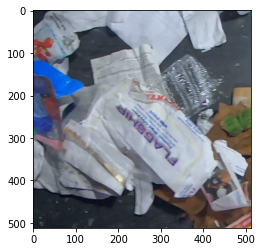

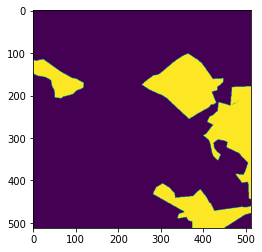

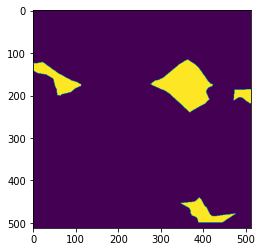

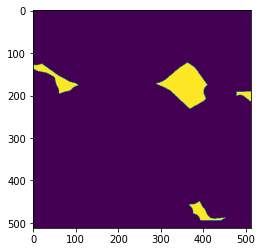

In [ ]:
# sanity check
idx = np.random.randint(3002)
image, label = my_dataset[idx]

image = image.permute((1, 2, 0)).cpu()
image -= image.min()
image /= image.max()
plt.imshow(image)
plt.show()
plt.imshow(label[4].cpu())
plt.show()
plt.imshow(label[5].cpu())
plt.show()
plt.imshow(label[6].cpu())
plt.show()

In [ ]:
from torch.utils.data import DataLoader

num_workers = 2
train_dataloader = DataLoader(my_dataset, batch_size=8, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)

In [ ]:
# 类别预测需要用softmax

In [ ]:
def criterion(pred, target):
    return F.binary_cross_entropy_with_logits(pred, target)
    # p0, t0 = pred[..., 0], target[..., 0]
    # p1, t1 = pred[..., 1], target[..., 1]
    # p2345, t2345 = pred[..., 2:6], target[..., 2:6]

    # loss0 = F.binary_cross_entropy_with_logits(p0, t0)
    # loss1 = F.binary_cross_entropy_with_logits(p1, t1)
    # loss2 = F.cross_entropy(p2345, t2345)
    # loss = 0.33 * loss0 + 0.33 * loss1 + 0.33 * loss2
    # return loss

In [ ]:
model = resnet50(pretrained=True, num_classes=7).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
set_learning_rate(optimizer, 0.000001)

model.train()
for idx, (image, label) in enumerate(train_dataloader):
    image = image.cuda()
    label = label.cuda()

    y_pred = model(image)
    loss = criterion(y_pred, label)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (idx + 1) % 10 == 0:
        print(idx, loss.item())

9 0.05952409282326698
19 0.06962575763463974
29 0.06509239971637726
39 0.07229150831699371
49 0.09204638749361038
59 0.11618275195360184
69 0.0905587375164032
79 0.08295116573572159
89 0.08892261236906052
99 0.06961076706647873
109 0.10792477428913116
119 0.06330104917287827
129 0.08219753205776215
139 0.09568651020526886
149 0.07648372650146484
159 0.096082903444767
169 0.08382847160100937
179 0.08457954227924347
189 0.10534872859716415
199 0.12154915183782578
209 0.08859429508447647
219 0.11066926270723343
229 0.09417560696601868
239 0.10350575298070908
249 0.08453430235385895
259 0.07592549920082092
269 0.08043801784515381
279 0.09089391678571701
289 0.09103497862815857
299 0.07761874794960022
309 0.11471675336360931
319 0.14708589017391205
329 0.095637246966362
339 0.0728902667760849
349 0.15210680663585663
359 0.16453665494918823
369 0.1224185973405838


In [ ]:
torch.save(model.state_dict(), "./drive/MyDrive/cs523_project/saved_model_0")

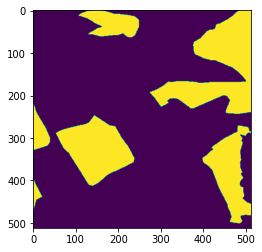

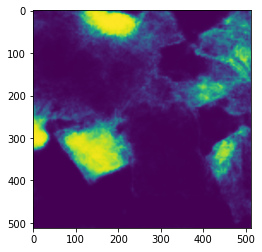

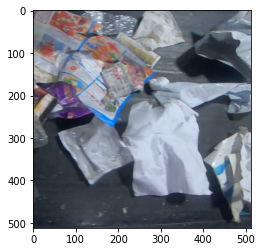

In [ ]:
idx = np.random.randint(3002)
image, label = my_dataset[idx]

model.eval()
y_pred = model(image[None].cuda())

plt.imshow(label[4].cpu().detach())
plt.show()

plt.imshow(torch.sigmoid(y_pred)[0, 4].cpu().detach())
plt.show()

image = image.permute((1, 2, 0)).cpu()
image -= image.min()
image /= image.max()
plt.imshow(image)
plt.show()

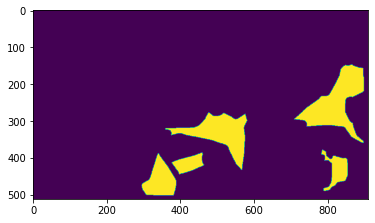

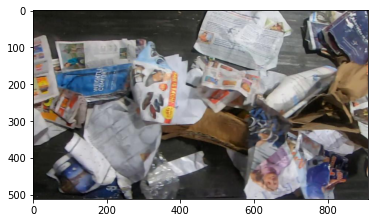

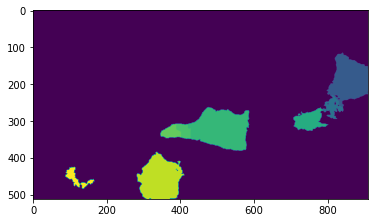

In [ ]:
set_plot_size("small")

img_path = "./images/02060.jpg"
path_label = "./labels/02060.npz"

label = torch.tensor(np.load(path_label)["arr_0"].transpose((2, 0, 1)), dtype=torch.float)
plt.imshow(label[5])
plt.show()

to_tensor = torchvision.transforms.ToTensor()
normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

image = Image.open(img_path)
image = to_tensor(image)
plt.imshow(image.permute((1, 2, 0)))
plt.show()
image = normalize(image)

x = image[None].cuda()

model.eval()
y = model(x)
y = torch.sigmoid(y)

y = y.detach().cpu().numpy()
thr = 0.4
y[y > thr] = 1
y[y <= thr] = 0

kernels = np.zeros((3, 512, 910), dtype="uint8")

kernels[0] = y[0, 4]
kernels[1] = y[0, 5]
kernels[2] = y[0, 6]

result_pse = pse(kernels, 100)
plt.imshow(result_pse)
plt.show()